BÀI THỰC HÀNH PHẦN
MULTI-CLASS SUPPORT VECTOR MACHINE

Ví dụ 1: SVM đa lớp theo Crammer–Singer (Dual + QP)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
n_per_class = 100
means = [[0,0], [3,3], [0,4]]
cov = [[0.4,0],[0,0.4]]

1

X_list , y_list = [], []
for k, mu in enumerate(means):
  Xk = np.random.multivariate_normal(mu, cov, n_per_class)
  yk = np.full(n_per_class , k)
  X_list.append(Xk)
  y_list.append(yk)
X = np.vstack(X_list)
y = np.concatenate(y_list)
n, d = X.shape
K = len(np.unique(y))

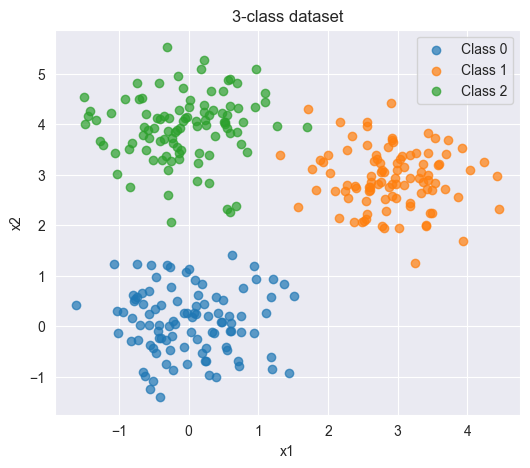

In [2]:
plt.figure(figsize=(6,5))
for k in range(K):
  plt.scatter(X[y==k,0], X[y==k,1], label=f"Class {k}", alpha=0.7)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("3-class dataset")
plt.grid(True)
plt.show()

In [3]:

# 2. Build (i,k) pairs
pairs = [(i, k) for i in range(n) for k in range(K) if k != y[i]]
m = len(pairs)


In [4]:
# 3. Build QP matrices
from cvxopt import matrix, solvers
C = 1.0
solvers.options['show_progress'] = False

# Matrix P
P = np.zeros((m, m))
for p, (i, k) in enumerate(pairs):
    for q, (j, l) in enumerate(pairs):
        val = 0.0
        if y[i] == y[j]:
            val += 1
        if y[i] == l:
            val -= 1
        if y[j] == k:
            val -= 1
        if k == l:
            val += 1
        P[p, q] = val * np.dot(X[i], X[j])

# Vector q
q = -np.ones(m)

# Constraints α >= 0
G = -np.eye(m)
h = np.zeros(m)

# Constraints sum_k α_{i,k} <= C
A = np.zeros((n, m))
for idx, (i, k) in enumerate(pairs):
    A[i, idx] = 1
b = C * np.ones(n)

# -------------------------
# 4. Solve QP
# -------------------------
solution = solvers.qp(
    matrix(P), matrix(q),
    matrix(G), matrix(h),
    matrix(A), matrix(b)
)

alpha = np.array(solution['x']).flatten()


In [8]:
# 5. Support vectors
eps = 1e-5
sv_idx = np.where(alpha > eps)[0]
support_points = np.unique([pairs[i][0] for i in sv_idx])

print(f"Number of support vectors: {len(support_points)}")


Number of support vectors: 300


In [5]:
# 6. Recover W
W = np.zeros((K, d))
for idx, (i, k) in enumerate(pairs):
    W[y[i]] += alpha[idx] * X[i]
    W[k]    -= alpha[idx] * X[i]


1.12 Yêu cầu phát triển

NameError: name 'support_points' is not defined

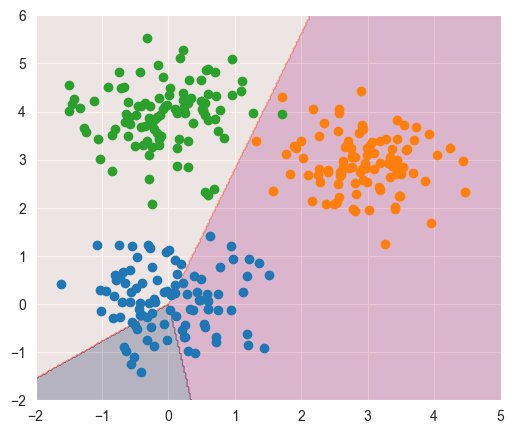

In [6]:

# 7. Decision regions
xx, yy = np.meshgrid(
    np.linspace(-2, 5, 300),
    np.linspace(-2, 6, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]
scores = grid @ W.T
pred = np.argmax(scores, axis=1)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, pred.reshape(xx.shape), alpha=0.25)

for k in range(K):
    plt.scatter(X[y==k,0], X[y==k,1], label=f"Class {k}")

plt.scatter(
    X[support_points,0],
    X[support_points,1],
    s=120, facecolors='none', edgecolors='k',
    label='Support Vectors'
)

plt.legend()
plt.title("Crammer–Singer SVM (Dual)")
plt.show()


In [7]:

# 8. Training accuracy
scores_train = X @ W.T
y_pred = np.argmax(scores_train, axis=1)

accuracy = np.mean(y_pred == y)
print(f"Training accuracy: {accuracy*100:.2f}%")


Training accuracy: 71.00%


Ví dụ 2: Multiclass SVM với Hinge Loss

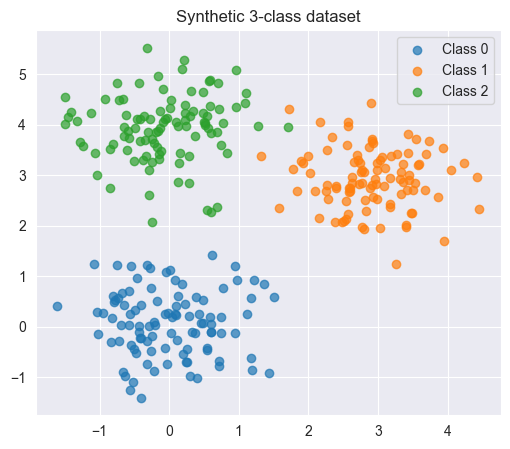

In [8]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

n_per_class = 100
means = [[0, 0], [3, 3], [0, 4]]
cov = [[0.4, 0], [0, 0.4]]

X_list, y_list = [], []
for k, mu in enumerate(means):
    Xk = np.random.multivariate_normal(mu, cov, n_per_class)
    yk = np.full(n_per_class, k)
    X_list.append(Xk)
    y_list.append(yk)

X = np.vstack(X_list)
y = np.concatenate(y_list)

n, d = X.shape
K = len(np.unique(y))

# Plot data
plt.figure(figsize=(6,5))
for k in range(K):
    plt.scatter(X[y==k,0], X[y==k,1], label=f"Class {k}", alpha=0.7)
plt.legend()
plt.title("Synthetic 3-class dataset")
plt.grid(True)
plt.show()


# -------------------------
# Standardize data (VERY IMPORTANT)
# -------------------------
X_mean = X.mean(axis=0)
X_std = X.std(axis=0) + 1e-8
X = (X - X_mean) / X_std


In [9]:

# Multiclass SVM with Hinge Loss (FIXED)
W = np.zeros((K, d))

lr = 0.001        
lam = 1e-4     
epochs = 500

loss_history = []

for epoch in range(epochs):
    grad = np.zeros_like(W)
    total_loss = 0.0
    for i in range(n):
        scores = X[i] @ W.T
        margins = scores - scores[y[i]] + 1
        margins[y[i]] = 0

        k_star = np.argmax(margins)

        if margins[k_star] > 0:
            total_loss += margins[k_star]
            grad[y[i]] -= X[i]
            grad[k_star] += X[i]

    # average gradient + regularization
    grad = grad / n + lam * W

    W -= lr * grad
    loss_history.append(total_loss / n)


    if epoch % 50 == 0:
        print(f"Epoch {epoch}, loss = {loss_history[-1]:.4f}")

Epoch 0, loss = 1.0000
Epoch 50, loss = 0.9544
Epoch 100, loss = 0.9090
Epoch 150, loss = 0.8637
Epoch 200, loss = 0.8183
Epoch 250, loss = 0.7730
Epoch 300, loss = 0.7276
Epoch 350, loss = 0.6823
Epoch 400, loss = 0.6369
Epoch 450, loss = 0.5916


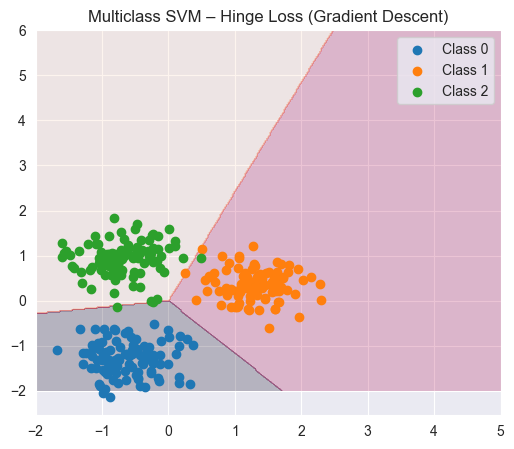

In [10]:
# Decision regions
xx, yy = np.meshgrid(
    np.linspace(-2, 5, 300),
    np.linspace(-2, 6, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]
scores = grid @ W.T
pred = np.argmax(scores, axis=1)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, pred.reshape(xx.shape), alpha=0.25)

for k in range(K):
    plt.scatter(X[y==k,0], X[y==k,1], label=f"Class {k}")

plt.legend()
plt.title("Multiclass SVM – Hinge Loss (Gradient Descent)")
plt.show()


In [11]:
scores_train = X @ W.T
y_pred = np.argmax(scores_train, axis=1)

acc = np.mean(y_pred == y)
print(f"Training accuracy: {acc*100:.2f}%")


Training accuracy: 99.00%


Ví dụ 3: SVM đa lớp với scikit-learn

In [12]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt


X_mean = X.mean(axis=0)
X_std = X.std(axis=0) + 1e-8
X_stdized = (X - X_mean) / X_std


clf = SVC(kernel='linear', C=1.0)
clf.fit(X_stdized, y)


SVC(kernel='linear')

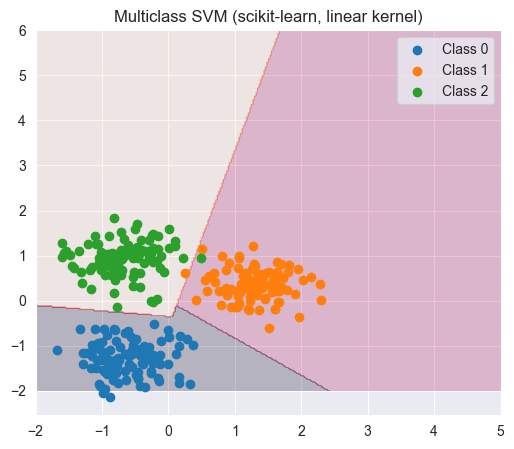

In [13]:
# Decision regions
xx, yy = np.meshgrid(
    np.linspace(-2, 5, 300),
    np.linspace(-2, 6, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]
grid_std = (grid - X_mean) / X_std

pred = clf.predict(grid_std)

plt.figure(figsize=(6,5))
plt.contourf(xx, yy, pred.reshape(xx.shape), alpha=0.25)

for k in np.unique(y):
    plt.scatter(X[y==k,0], X[y==k,1], label=f"Class {k}")

plt.legend()
plt.title("Multiclass SVM (scikit-learn, linear kernel)")
plt.show()


In [14]:
y_pred = clf.predict(X_stdized)
acc = np.mean(y_pred == y)
print(f"Training accuracy (sklearn SVM): {acc*100:.2f}%")


Training accuracy (sklearn SVM): 99.33%


Ví dụ 4: Iris Dataset

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load Iris dataset
X, y = load_iris(return_X_y=True)



In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [17]:
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_scaled, y)


SVC(kernel='linear')

In [18]:
y_pred = clf.predict(X_scaled)
acc = accuracy_score(y, y_pred)
print("Accuracy:", acc)


Accuracy: 0.9666666666666667


In [19]:
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[50  0  0]
 [ 0 46  4]
 [ 0  1 49]]


In [20]:
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.92      0.95        50
           2       0.92      0.98      0.95        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150


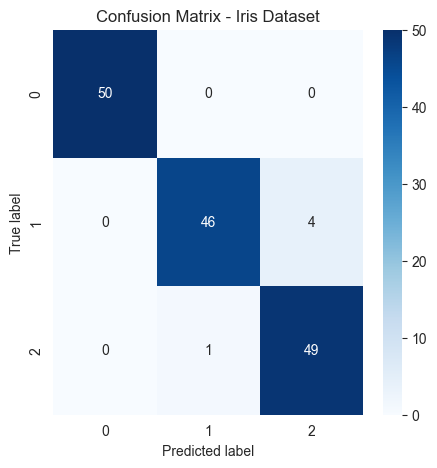

In [21]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Iris Dataset")
plt.show()


Ví dụ 5: Wine Dataset

In [22]:
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix


In [23]:
# Load Wine dataset
X, y = load_wine(return_X_y=True)

# Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [24]:
C_values = [0.01, 0.1, 1, 10, 100]

for C in C_values:
    clf = SVC(kernel='linear', C=C)
    clf.fit(X_scaled, y)
    y_pred = clf.predict(X_scaled)
    acc = accuracy_score(y, y_pred)
    print(f"C = {C:>6}, Accuracy = {acc:.4f}")


C =   0.01, Accuracy = 0.9944
C =    0.1, Accuracy = 0.9944
C =      1, Accuracy = 1.0000
C =     10, Accuracy = 1.0000
C =    100, Accuracy = 1.0000


In [25]:
clf_ovr = LinearSVC(C=1.0, multi_class='ovr', max_iter=5000)
clf_ovr.fit(X_scaled, y)

y_pred_ovr = clf_ovr.predict(X_scaled)
acc_ovr = accuracy_score(y, y_pred_ovr)

print("OvR Accuracy:", acc_ovr)


OvR Accuracy: 1.0


In [26]:
clf_ovo = SVC(kernel='linear', C=1.0)
clf_ovo.fit(X_scaled, y)

y_pred_ovo = clf_ovo.predict(X_scaled)
acc_ovo = accuracy_score(y, y_pred_ovo)

print("OvO Accuracy:", acc_ovo)


OvO Accuracy: 1.0


7.4 Bài tập từ giải A – Dữ liệu tự chọn

In [28]:

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
X, y = load_digits(return_X_y=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X.shape, y.shape)

(1797, 64) (1797,)


In [29]:
clf = SVC(kernel='rbf', C=10, gamma=0.01)
start = time.time()
clf.fit(X, y)
end = time.time()

print("Accuracy:", accuracy_score(y, clf.predict(X)))
print("Training time:", end - start)


Accuracy: 1.0
Training time: 0.18308782577514648


7.5 Bài tập từ giải B – Phát triển chương trình

In [30]:
def train_minibatch_svm(X, y, K, lr=0.01, lam=0.01, batch_size=16, epochs=100):
    n, d = X.shape
    W = np.zeros((K, d))

    for epoch in range(epochs):
        idx = np.random.permutation(n)
        for i in range(0, n, batch_size):
            batch = idx[i:i+batch_size]
            grad = lam * W

            for j in batch:
                scores = X[j] @ W.T
                margins = scores - scores[y[j]] + 1
                margins[y[j]] = 0
                k_star = np.argmax(margins)

                if margins[k_star] > 0:
                    grad[y[j]] -= X[j]
                    grad[k_star] += X[j]

            W -= lr * grad
    return W


In [31]:
K = len(np.unique(y))

for lr in [0.1, 0.01, 0.001]:
    W = train_minibatch_svm(X_scaled, y, K=K, lr=lr)
    y_pred = np.argmax(X_scaled @ W.T, axis=1)
    acc = accuracy_score(y, y_pred)
    print(f"lr = {lr}, accuracy = {acc:.4f}")


lr = 0.1, accuracy = 0.9777
lr = 0.01, accuracy = 0.9978
lr = 0.001, accuracy = 0.9955


7.6 Kernel & mở rộng

In [32]:
for gamma in [0.001, 0.01, 0.1, 1]:
    clf = SVC(kernel='rbf', C=1, gamma=gamma)
    clf.fit(X_scaled, y)
    acc = accuracy_score(y, clf.predict(X_scaled))
    print(f"gamma={gamma}, acc={acc:.4f}")


gamma=0.001, acc=0.9622
gamma=0.01, acc=0.9961
gamma=0.1, acc=1.0000
gamma=1, acc=1.0000
